In [ ]:
# André Lucas Pierote Rodrigues Vasconcelos 11356540
# Leonardo Isao Komura 11261656

In [17]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='3'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
import tensorflow as tf
from tensorflow import keras
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras import optimizers
import matplotlib.pyplot as plt; import numpy as np
import matplotlib.image as mpimg
import cv2

In [18]:
#get_bd.py
url="http://www.lps.usp.br/hae/psi3472/ep-2020/feiFrontG2C.zip"
import os; nomeArq=os.path.split(url)[1]
if not os.path.exists(nomeArq):
    print("Baixando o arquivo",nomeArq,"para diretorio default",os.getcwd())
    os.system("wget -nc -U 'Firefox/50.0' "+url)
else:
    print("O arquivo",nomeArq,"ja existe no diretorio default",os.getcwd())
print("Descompactando arquivos novos de",nomeArq)
os.system("unzip -u "+nomeArq)

O arquivo feiFrontG2C.zip ja existe no diretorio default /content
Descompactando arquivos novos de feiFrontG2C.zip


0

In [19]:
# Funções de leitura das imagens e criação dos tensores de dados
def readTrain():
    n = 150
    rows = 384
    columns = 256
    AX=np.empty((2*n,rows,columns), dtype='uint8')
    AY=np.empty((2*n,rows,columns,3), dtype='uint8')
    
    k = 0
    for i in range(n):
        if(i < 9):
            ac = "00" + str(i+1) + "ac" + "." + "jpg"
            al = "00" + str(i+1) + "al" + "." + "jpg"
            bc = "00" + str(i+1) + "bc" + "." + "jpg"
            bl = "00" + str(i+1) + "bl" + "." + "jpg"
        elif(9 <= i < 99):
            ac = "0" + str(i+1) + "ac" + "." + "jpg"
            al = "0" + str(i+1) + "al" + "." + "jpg"
            bc = "0" + str(i+1) + "bc" + "." + "jpg"
            bl = "0" + str(i+1) + "bl" + "." + "jpg"
        else:
            ac = str(i+1) + "ac" + "." + "jpg"
            al = str(i+1) + "al" + "." + "jpg"
            bc = str(i+1) + "bc" + "." + "jpg"
            bl = str(i+1) + "bl" + "." + "jpg"
        
        AX[k,:,:] = cv2.imread(al, cv2.IMREAD_GRAYSCALE)
        AY[k,:,:,:] = cv2.imread(ac, cv2.IMREAD_COLOR)
        AX[k+1,:,:] = cv2.imread(bl, cv2.IMREAD_GRAYSCALE)
        AY[k+1,:,:,:] = cv2.imread(bc, cv2.IMREAD_COLOR)
        
        k = k+2
    
    return AX, AY
        
def readTest():
    n = 50
    rows = 384
    columns = 256
    
    QX=np.empty((2*n,rows,columns), dtype='uint8')
    QY=np.empty((2*n,rows,columns,3), dtype='uint8')
    
    k = 0
    for i in range(150, 200):
        ac = str(i+1) + "ac" + "." + "jpg"
        al = str(i+1) + "al" + "." + "jpg"
        bc = str(i+1) + "bc" + "." + "jpg"
        bl = str(i+1) + "bl" + "." + "jpg" 

        QY[k,:,:,:] = cv2.imread(ac,cv2.IMREAD_COLOR)
        QX[k,:,:] = cv2.imread(al,cv2.IMREAD_GRAYSCALE)
        QY[k+1,:,:,:] = cv2.imread(bc,cv2.IMREAD_COLOR)
        QX[k+1,:,:] = cv2.imread(bl,cv2.IMREAD_GRAYSCALE)
        
        k = k+2
    
    return QX, QY

In [20]:
def writeTrain(img, path):
    n = 150
    k = 0
    for i in range(n):
        if(i < 9):
            ap = path + "/" + "00" + str(i+1) + "ap" + "." + "jpg"
            bp = path + "/" + "00" + str(i+1) + "bp" + "." + "jpg"
        elif(9 <= i < 99):
            ap = path + "/" + "0" + str(i+1) + "ap" + "." + "jpg"
            bp = path + "/" + "0" + str(i+1) + "bp" + "." + "jpg"
        else:
            ap = path + "/" + str(i+1) + "ap" + "." + "jpg"
            bp = path + "/" + str(i+1) + "bp" + "." + "jpg"
        
        cv2.imwrite(ap, img[k])
        cv2.imwrite(bp, img[k+1])
        k = k+2
        
def writeTest(img, path):
    n = 50
    k = 0
    for i in range(150, 200):
        ap = path + "/" + str(i+1) + "ap" + "." + "jpg"
        bp = path + "/" + str(i+1) + "bp" + "." + "jpg"
    
        cv2.imwrite(ap, img[k])
        cv2.imwrite(bp, img[k+1])
        k = k+2

(-0.5, 255.5, 383.5, -0.5)

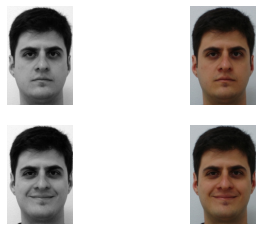

In [21]:
# Realizando a leitura das imagens
AX, AY = readTrain()
QX, QY = readTest()

# Imprimindo as imagens para verificação
fig, axs = plt.subplots(2, 2)
axs[0,0].imshow(AX[0], cmap='gray')
axs[0,0].axis('off')
rgb=cv2.cvtColor(AY[0], cv2.COLOR_BGR2RGB)
axs[0,1].imshow(rgb)
axs[0,1].axis('off')
axs[1,0].imshow(AX[1], cmap='gray')
axs[1,0].axis('off')
rgb1=cv2.cvtColor(AY[1], cv2.COLOR_BGR2RGB)
axs[1,1].imshow(rgb1)
axs[1,1].axis('off')

In [22]:
# Passando os dados para float32
ax = np.float32(AX.copy())
qx = np.float32(QX.copy())
ay = np.empty((AY.shape[0], AY.shape[1], AY.shape[2], AY.shape[3]), dtype='float32')
qy = np.empty((QY.shape[0], QY.shape[1], QY.shape[2], QY.shape[3]), dtype='float32')

# Transformando os dados de BGR para CieLAB
for i in range(ay.shape[0]):
    ay[i] = cv2.cvtColor(AY[i], cv2.COLOR_BGR2LAB)
    ay[i] = ay[i]/255-0.5
    
for i in range(qy.shape[0]):
    qy[i] = cv2.cvtColor(QY[i], cv2.COLOR_BGR2LAB)
    qy[i] = qy[i]/255-0.5

In [23]:
print("input = ", ax.shape)
print("output = ", ay.shape)

input =  (300, 384, 256)
output =  (300, 384, 256, 3)


In [24]:
def cnn(input_size=(384,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    conv2 = Conv2D(64, (3,3), activation='relu', strides=2, padding='same')(conv1)
    batch1 = BatchNormalization()(conv2)
    conv3 = Conv2D(128, (3,3), activation='relu', padding='same')(batch1)
    conv4 = Conv2D(128, (3,3), activation='relu', strides=2, padding='same')(conv3)
    batch2 = BatchNormalization()(conv4)
    conv5 = Conv2D(256, (3,3), activation='relu', padding='same')(batch2)
    conv6 = Conv2D(256, (3,3), activation='relu', strides=2, padding='same')(conv5)
    batch3 = BatchNormalization()(conv6)
    conv7 = Conv2D(512, (3,3), activation='relu', padding='same')(batch3)
    conv8 = Conv2D(256, (3,3), activation='relu', padding='same')(conv7)
    conv9 = Conv2D(128, (3,3), activation='relu', padding='same')(conv8)
    ups1 = UpSampling2D((2,2))(conv9)
    conv10 = Conv2D(64, (3,3), activation='relu', padding='same')(ups1)
    ups2 = UpSampling2D((2,2))(conv10)
    conv11 = Conv2D(32, (3,3), activation='relu', padding='same')(ups2)
    conv12 = Conv2D(3, (3,3), activation='tanh', padding='same')(conv11)
    ups3 = UpSampling2D((2,2))(conv12)
    
    model = Model(inputs = inputs, outputs = ups3)
    model.compile(optimizer=keras.optimizers.Adam(), loss='mean_squared_error')
    from tensorflow.keras.utils import plot_model
    plot_model(model, to_file='fcnet-train1.png', show_shapes=True)
    model.summary()
    model.save('model.h5')
    return model

In [25]:
model = cnn()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 384, 256, 1)]     0         
                                                                 
 conv2d_12 (Conv2D)          (None, 384, 256, 64)      640       
                                                                 
 conv2d_13 (Conv2D)          (None, 192, 128, 64)      36928     
                                                                 
 batch_normalization_3 (Batc  (None, 192, 128, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_14 (Conv2D)          (None, 192, 128, 128)     73856     
                                                                 
 conv2d_15 (Conv2D)          (None, 96, 64, 128)       147584    
                                                           

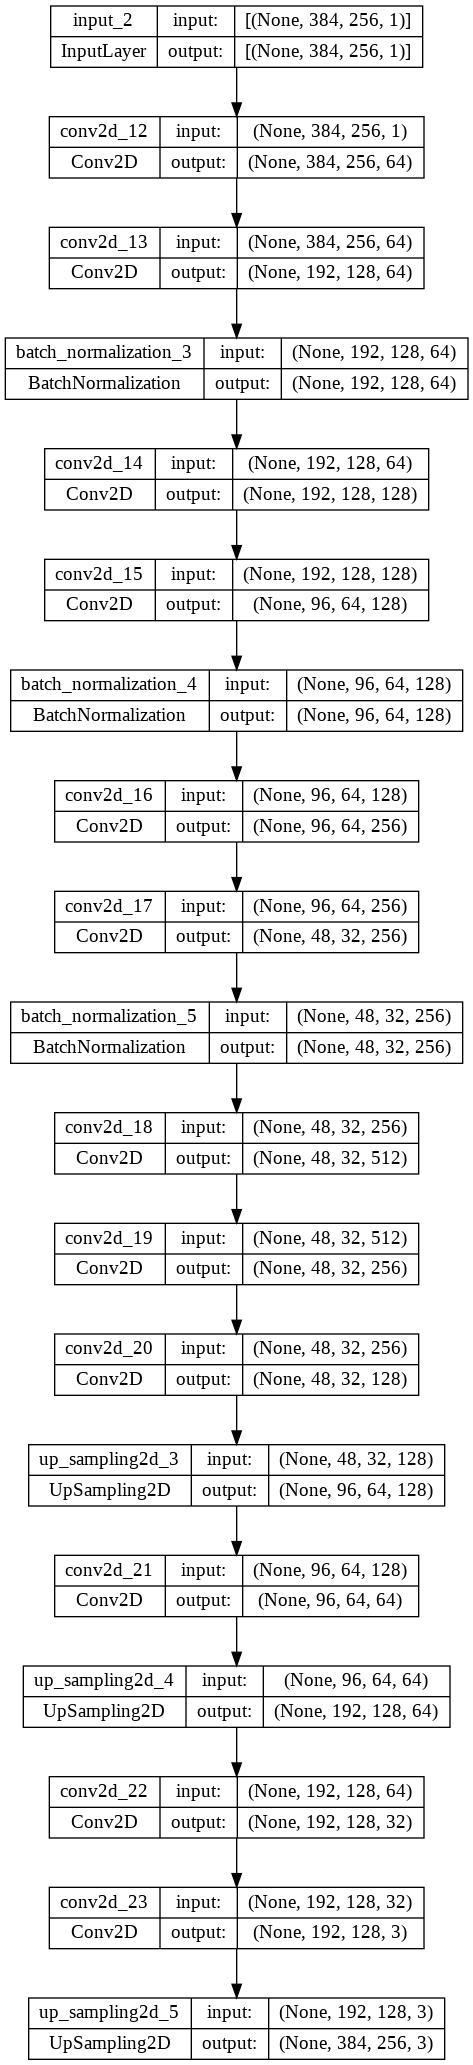

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [27]:
history = model.fit(ax, ay, batch_size=5, epochs=50, verbose=2)

Epoch 1/50
60/60 - 7s - loss: 0.0330 - 7s/epoch - 110ms/step
Epoch 2/50
60/60 - 6s - loss: 0.0022 - 6s/epoch - 95ms/step
Epoch 3/50
60/60 - 6s - loss: 0.0017 - 6s/epoch - 95ms/step
Epoch 4/50
60/60 - 6s - loss: 0.0015 - 6s/epoch - 96ms/step
Epoch 5/50
60/60 - 6s - loss: 0.0015 - 6s/epoch - 96ms/step
Epoch 6/50
60/60 - 6s - loss: 0.0010 - 6s/epoch - 97ms/step
Epoch 7/50
60/60 - 6s - loss: 0.0011 - 6s/epoch - 97ms/step
Epoch 8/50
60/60 - 6s - loss: 0.0010 - 6s/epoch - 97ms/step
Epoch 9/50
60/60 - 6s - loss: 9.2343e-04 - 6s/epoch - 98ms/step
Epoch 10/50
60/60 - 6s - loss: 7.9607e-04 - 6s/epoch - 98ms/step
Epoch 11/50
60/60 - 6s - loss: 9.7764e-04 - 6s/epoch - 99ms/step
Epoch 12/50
60/60 - 6s - loss: 8.6682e-04 - 6s/epoch - 99ms/step
Epoch 13/50
60/60 - 6s - loss: 7.8076e-04 - 6s/epoch - 99ms/step
Epoch 14/50
60/60 - 6s - loss: 7.9253e-04 - 6s/epoch - 100ms/step
Epoch 15/50
60/60 - 6s - loss: 8.1079e-04 - 6s/epoch - 100ms/step
Epoch 16/50
60/60 - 6s - loss: 6.8825e-04 - 6s/epoch - 100ms/st

In [28]:
ap = model.predict(ax)
qp = model.predict(qx)

4/4 [==============================] - 1s 164ms/step


In [29]:
AP = np.empty((ap.shape[0], ap.shape[1], ap.shape[2], ap.shape[3]), dtype='float32')
for i in range(AP.shape[0]):
    AP[i] = cv2.cvtColor(np.array((ap[i]+0.5)*255, dtype='uint8'), cv2.COLOR_LAB2BGR)

QP = np.empty((qp.shape[0], qp.shape[1], qp.shape[2], qp.shape[3]), dtype='float32')
for i in range(QP.shape[0]):
    QP[i] = cv2.cvtColor(np.array((qp[i]+0.5)*255, dtype='uint8'), cv2.COLOR_LAB2BGR)

(-0.5, 255.5, 383.5, -0.5)

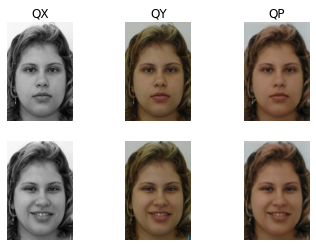

In [30]:
fig, axs = plt.subplots(2, 3)
axs[0,0].imshow(QX[0], cmap='gray')
axs[0,0].axis('off')
axs[0,0].set_title('QX')
rgb=cv2.cvtColor(np.array(QY[0], dtype='uint8'), cv2.COLOR_BGR2RGB)
axs[0,1].imshow(rgb)
axs[0,1].axis('off')
axs[0,1].set_title('QY')
rgb1=cv2.cvtColor(np.array(QP[0], dtype='uint8'), cv2.COLOR_BGR2RGB)
axs[0,2].imshow(rgb1)
axs[0,2].axis('off')
axs[1,0].imshow(QX[1], cmap='gray')
axs[1,0].axis('off')
axs[0,2].set_title('QP')
rgb2=cv2.cvtColor(np.array(QY[1], dtype='uint8'), cv2.COLOR_BGR2RGB)
axs[1,1].imshow(rgb2)
axs[1,1].axis('off')
rgb3=cv2.cvtColor(np.array(QP[1], dtype='uint8'), cv2.COLOR_BGR2RGB)
axs[1,2].imshow(rgb3)
axs[1,2].axis('off')

In [31]:
# Gravando as imagens coloridas
path = "."
writeTrain(AP, path)
writeTest(QP, path)

In [32]:
# Cálculo do erro
import sys
def MSE_RGB(indice):
 ay=cv2.imread("%03dac.jpg"%indice,1)
 if ay is None: sys.exit("Erro leitura %03dac.jpg"%indice)
 ap=cv2.imread("%03dap.jpg"%indice,1)
 if ap is None: sys.exit("Erro leitura %03dap.jpg"%indice)
 ay = ay/255.0-0.5; ap = ap/255.0-0.5
 mse1 = np.square(np.subtract(ay,ap)).mean()
 ay=cv2.imread("%03dbc.jpg"%indice,1)
 if ay is None: sys.exit("Erro leitura","%03dbc.jpg"%indice)
 ap=cv2.imread("%03dbp.jpg"%indice,1)
 if ap is None: sys.exit("Erro leitura","%03dbp.jpg"%indice)
 ay = ay/255.0-0.5; ap = ap/255.0-0.5
 mse2 = np.square(np.subtract(ay,ap)).mean()
 mse = (mse1+mse2)/2
 return mse
def MSE_AB(indice):
 ay=cv2.imread("%03dac.jpg"%indice,1)
 if ay is None: sys.exit("Erro leitura %03dac.jpg"%indice)
 ay=cv2.cvtColor(ay,cv2.COLOR_BGR2LAB);
 ap=cv2.imread("%03dap.jpg"%indice,1)
 if ap is None: sys.exit("Erro leitura %03dap.jpg"%indice)
 ap=cv2.cvtColor(ap,cv2.COLOR_BGR2LAB);
 ay = ay/255.0-0.5; ap = ap/255.0-0.5
 mse1 = np.square(np.subtract(ay[:,:,1:3],ap[:,:,1:3])).mean()
 ay=cv2.imread("%03dbc.jpg"%indice,1)
 if ay is None: sys.exit("Erro leitura","%03dbc.jpg"%indice)
 ay=cv2.cvtColor(ay,cv2.COLOR_BGR2LAB);
 ap=cv2.imread("%03dbp.jpg"%indice,1)
 if ap is None: sys.exit("Erro leitura","%03dbp.jpg"%indice)
 ap=cv2.cvtColor(ap,cv2.COLOR_BGR2LAB);
 ay = ay/255.0-0.5; ap = ap/255.0-0.5
 mse2 = np.square(np.subtract(ay[:,:,1:3],ap[:,:,1:3])).mean()
 mse = (mse1+mse2)/2
 return mse

soma=0.0
for i in range(1,151): soma += MSE_RGB(i)
print("Training MSE_RGB=",soma/150)
soma=0.0
for i in range(151,201): soma += MSE_RGB(i)
print("Test MSE_RGB=",soma/50)
soma=0.0
for i in range(1,151): soma += MSE_AB(i)
print("Training MSE_AB=",soma/150)
soma=0.0
for i in range(151,201): soma += MSE_AB(i)
print("Test MSE_AB=",soma/50)


Training MSE_RGB= 0.0032360028688983027
Test MSE_RGB= 0.002966769493787778
Training MSE_AB= 0.00019339488197856928
Test MSE_AB= 0.00021930302795073812
